In [40]:
!pip3 install pandas_datareader
!pip3 install arch
!pip3 install statsmodels

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web

# 获取数据集
start = '2014-01-01'
end = '2026-01-01'

# 获取 EUR/USD 汇率数据（欧元对美元）
eurusd = web.DataReader('DEXUSEU', 'fred', start, end)

# 获取美元的利率（例如美国10年期国债收益率）
usd_rate = web.DataReader('GS10', 'fred', start, end)

# 获取欧元的利率（例如欧洲央行的基准利率）
eur_rate = web.DataReader('IR14280', 'fred', start, end)

# 数据预处理：欧元/美元汇率
eurusd.dropna(inplace=True)  # 删除缺失值
eurusd.rename(columns={'DEXUSEU': 'Price'}, inplace=True)  # 将列名改为 'Price'
eurusd['LogReturn'] = np.log(eurusd['Price'] / eurusd['Price'].shift(1))  # 计算对数收益率
eurusd.dropna(inplace=True)  # 删除包含NaN的行

# 数据预处理：美元利率
usd_rate.dropna(inplace=True)  # 删除缺失值
usd_rate.rename(columns={'GS10': 'USD_Rate'}, inplace=True)  # 将列名改为 'USD_Rate'
usd_rate = usd_rate.reindex(eurusd.index, method='ffill')  # 使用前向填充确保时间对齐

# 数据预处理：欧元利率（将基点转换为百分比）
eur_rate.dropna(inplace=True)  # 删除缺失值
eur_rate.rename(columns={'IR14280': 'EUR_Rate'}, inplace=True)  # 将列名改为 'EUR_Rate'
eur_rate = eur_rate.reindex(eurusd.index, method='ffill')  # 使用前向填充确保时间对齐
eur_rate['EUR_Rate'] = eur_rate['EUR_Rate'] / 100  # 将基点转换为百分比

# 合并所有数据
data = pd.merge(eurusd[['Price', 'LogReturn']], usd_rate[['USD_Rate']], left_index=True, right_index=True)
data = pd.merge(data, eur_rate[['EUR_Rate']], left_index=True, right_index=True)

# 划分训练集和测试集 (80% 用于训练，20% 用于测试)
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]  # 训练集
test_data = data.iloc[train_size:]  # 测试集

# 打印出训练集和测试集的基本信息
print(f"Training Set Length: {len(train_data)}")
print(f"Testing Set Length: {len(test_data)}")

# 显示训练集和测试集的前几行
print("Training Set Preview:")
print(train_data.head())
print("Testing Set Preview:")
print(test_data.head())


Training Set Length: 2249
Testing Set Length: 563
Training Set Preview:
             Price  LogReturn  USD_Rate  EUR_Rate
DATE                                             
2014-01-03  1.3606  -0.004693      2.86     1.673
2014-01-06  1.3636   0.002202      2.86     1.673
2014-01-07  1.3618  -0.001321      2.86     1.673
2014-01-08  1.3586  -0.002353      2.86     1.673
2014-01-09  1.3591   0.000368      2.86     1.673
Testing Set Preview:
             Price  LogReturn  USD_Rate  EUR_Rate
DATE                                             
2023-01-05  1.0522  -0.009271      3.53     3.005
2023-01-06  1.0619   0.009177      3.53     3.005
2023-01-09  1.0759   0.013098      3.53     3.005
2023-01-10  1.0737  -0.002047      3.53     3.005
2023-01-11  1.0740   0.000279      3.53     3.005


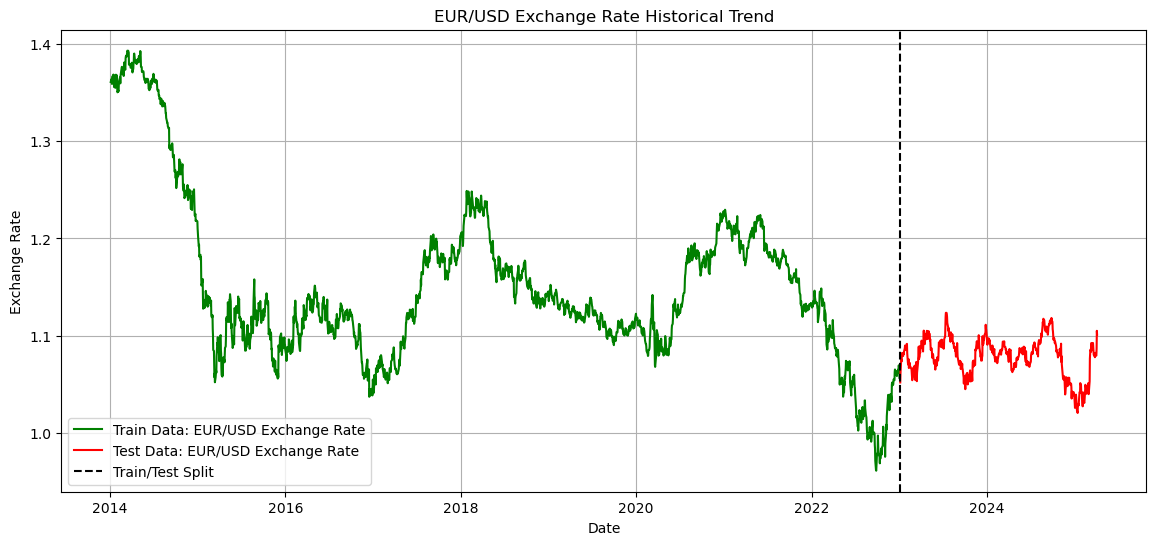

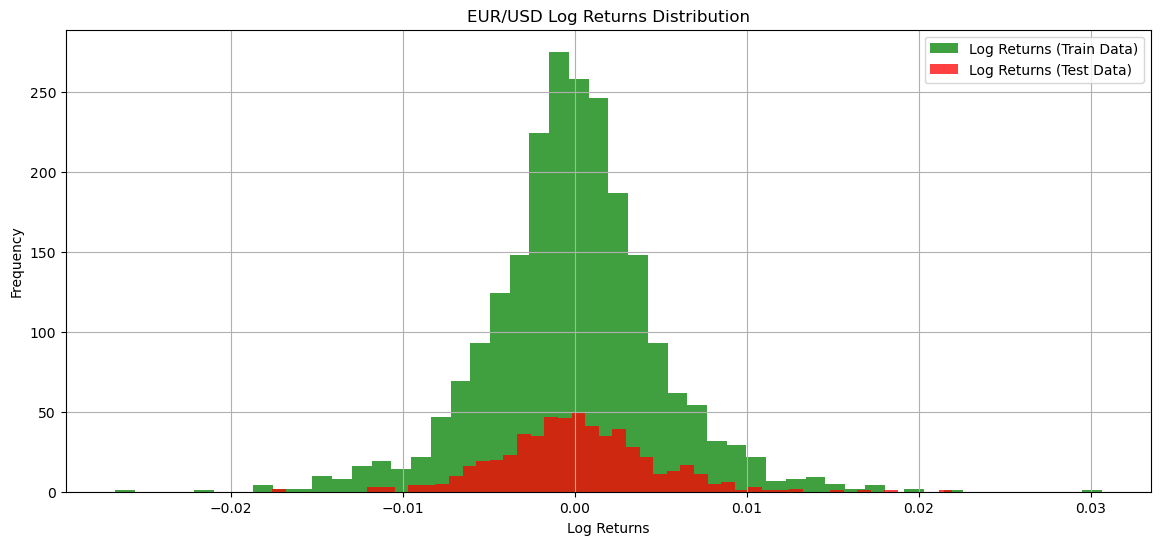

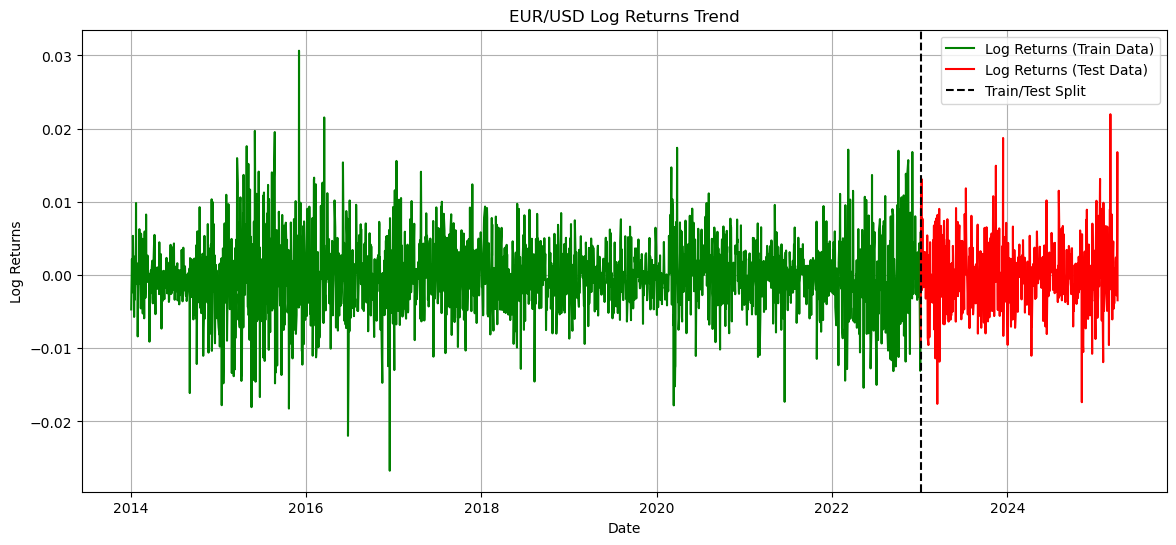

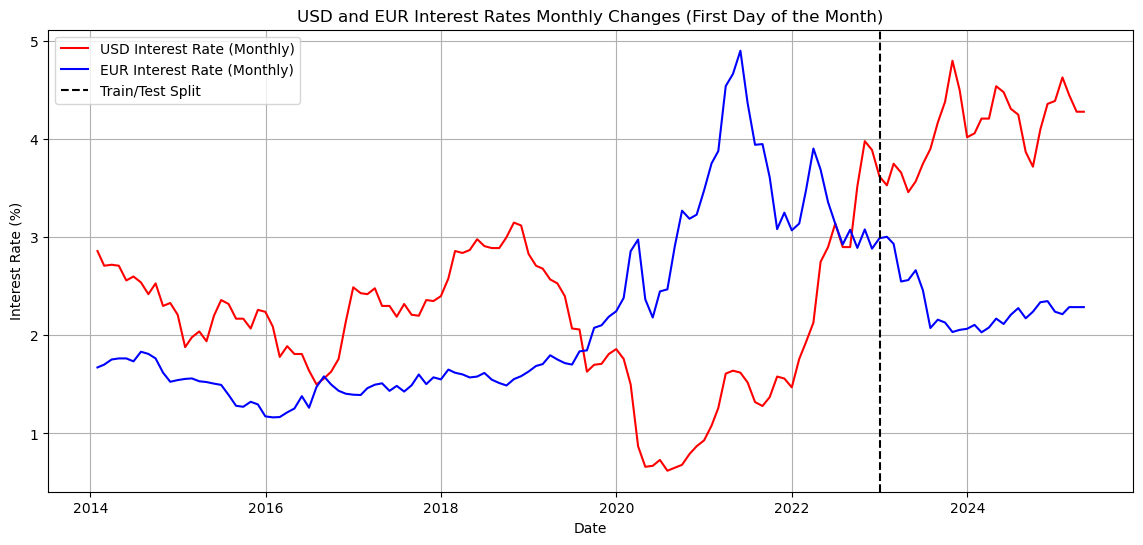

In [42]:
import matplotlib.pyplot as plt

# 可视化 EUR/USD 汇率变化（训练集和测试集的区分）
plt.figure(figsize=(14, 6))
plt.plot(train_data['Price'], label="Train Data: EUR/USD Exchange Rate", color='green')
plt.plot(test_data['Price'], label="Test Data: EUR/USD Exchange Rate", color='red')
# 添加竖直分割线
plt.axvline(x=train_data.index[-1], color='black', linestyle='--', label="Train/Test Split")
plt.title('EUR/USD Exchange Rate Historical Trend')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

# 可视化对数收益率的分布（统一颜色）
plt.figure(figsize=(14, 6))
plt.hist(train_data['LogReturn'], bins=50, alpha=0.75, color='green', label="Log Returns (Train Data)")
plt.hist(test_data['LogReturn'], bins=50, alpha=0.75, color='red', label="Log Returns (Test Data)")
plt.title('EUR/USD Log Returns Distribution')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# 可视化对数收益率的趋势（统一颜色）
plt.figure(figsize=(14, 6))
plt.plot(train_data['LogReturn'], label="Log Returns (Train Data)", color='green')
plt.plot(test_data['LogReturn'], label="Log Returns (Test Data)", color='red')
# 添加竖直分割线
plt.axvline(x=train_data.index[-1], color='black', linestyle='--', label="Train/Test Split")
plt.title('EUR/USD Log Returns Trend')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True)
plt.show()

# 合并美元利率和欧元利率的月度数据，取每月第一天的数据
usd_rate_monthly = usd_rate.resample('M').first()  # 每月第一天的数据
eur_rate_monthly = eur_rate.resample('M').first()  # 每月第一天的数据

# 可视化美元和欧元利率月度变化
plt.figure(figsize=(14, 6))
plt.plot(usd_rate_monthly['USD_Rate'], label="USD Interest Rate (Monthly)", color='red')
plt.plot(eur_rate_monthly['EUR_Rate'], label="EUR Interest Rate (Monthly)", color='blue')

# 添加竖直分割线，表示训练集和测试集的分割
plt.axvline(x=train_data.index[-1], color='black', linestyle='--', label="Train/Test Split")

# 添加标题和标签
plt.title('USD and EUR Interest Rates Monthly Changes (First Day of the Month)')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')

# 显示图例
plt.legend()

# 显示网格
plt.grid(True)

# 显示图形
plt.show()

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              LogReturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8898.93
Distribution:                  Normal   AIC:                          -17789.9
Method:            Maximum Likelihood   BIC:                          -17767.0
                                        No. Observations:                 2249
Date:                Fri, Apr 11 2025   Df Residuals:                     2248
Time:                        12:36:26   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -1.1226e-04  6.300e-08  -1781.800     

/Users/herongke/miniconda3/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


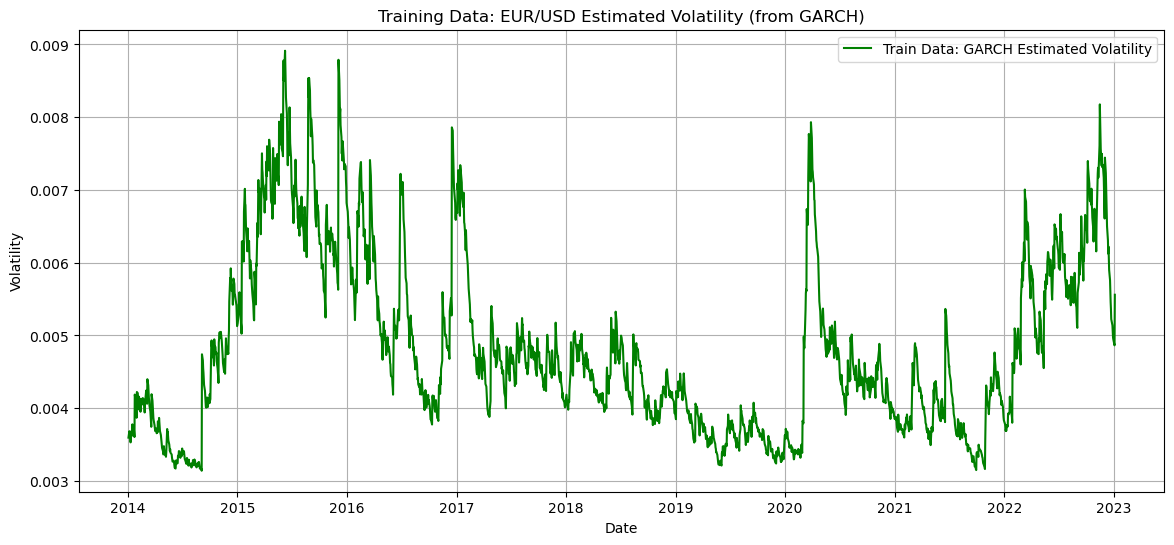

In [43]:
# 获取训练集对数收益率
train_log_returns = train_data['LogReturn']

# 定义并拟合 GARCH(1, 1) 模型
garch_model = arch_model(train_log_returns, vol='Garch', p=1, q=1, rescale=False)
garch_fitted = garch_model.fit(disp="off")  # 拟合模型，设置不显示详细信息

# 打印拟合结果
print(garch_fitted.summary())  # 打印拟合结果摘要，检查是否拟合良好

# 提取训练集的条件波动率（估算的波动率）
train_volatility = garch_fitted.conditional_volatility

# 可视化训练集的估计波动率
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_volatility, label="Train Data: GARCH Estimated Volatility", color='green')
plt.title('Training Data: EUR/USD Estimated Volatility (from GARCH)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)


Forecasted variance values:
                 h.1
DATE                
2016-04-04  0.000035
2016-04-05  0.000033
2016-04-06  0.000033
2016-04-07  0.000032
2016-04-08  0.000030


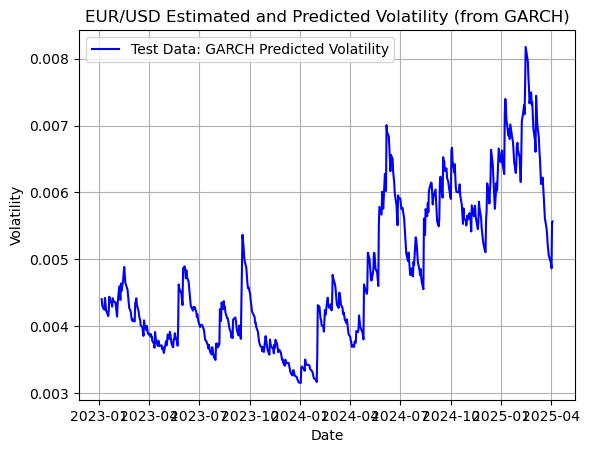

Train data size: 2249
Train size (index): 2023-01-04 00:00:00


In [44]:
# 预测未来的波动率
# 尝试从测试集开始点预测未来 1 天的波动率
forecast = garch_fitted.forecast(start=len(test_data), horizon=1)  # 设置horizon=1，预测未来1天

# 打印 forecast 的方差部分，查看是否有有效数据
print(f"Forecasted variance values:\n{forecast.variance.head()}")

# 获取预测的方差并计算标准差（波动率）
test_volatility = np.sqrt(forecast.variance.values[-len(test_data):, :])  # 获取测试集预测的波动率

# 检查预测的波动率是否为空
if test_volatility.size == 0:
    print("Error: No volatility predicted for the test set.")
# 可视化测试集的波动率
else:
    plt.plot(test_data.index, test_volatility, label="Test Data: GARCH Predicted Volatility", color='blue')
    plt.title('EUR/USD Estimated and Predicted Volatility (from GARCH)')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()

# 打印训练数据的基本信息
print(f"Train data size: {len(train_data)}")
print(f"Train size (index): {train_data.index[-1]}")


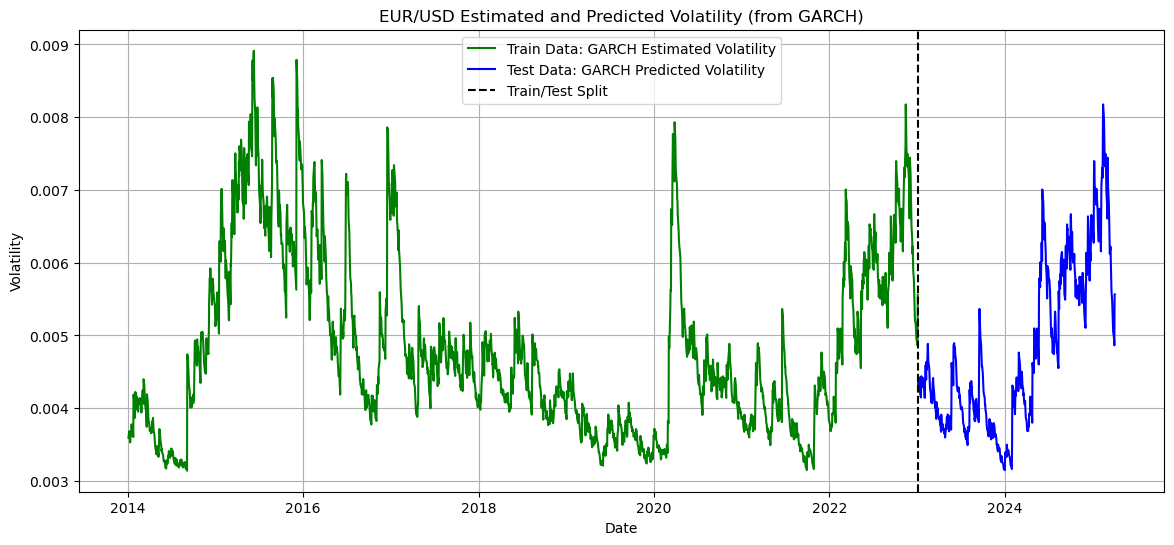

In [45]:
    # 可视化训练集和测试集的波动率
    plt.figure(figsize=(14, 6))
    
    # 画出训练集的波动率
    plt.plot(train_data.index, train_volatility, label="Train Data: GARCH Estimated Volatility", color='green')
    
    # 画出测试集的波动率
    plt.plot(test_data.index, test_volatility, label="Test Data: GARCH Predicted Volatility", color='blue')
    
    # 添加竖直分割线，表示训练集和测试集的分界点
    plt.axvline(x=train_data.index[-1], color='black', linestyle='--', label="Train/Test Split")

    plt.title('EUR/USD Estimated and Predicted Volatility (from GARCH)')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()


In [46]:
# 假设你已经得到了训练集的趋势(mu)和通过 GARCH 模型获得的波动率(sigma)
mu = train_data['LogReturn'].mean()  # 训练集计算的趋势
sigma = test_volatility  # 通过 GARCH 模型获得的波动率（已给出）

# 打印漂移率
print(f"Training Set Drift Rate (mu): {mu}")
# 将计算出的漂移率作为预测未来汇率的漂移参数


Training Set Drift Rate (mu): -0.00011225639614142533


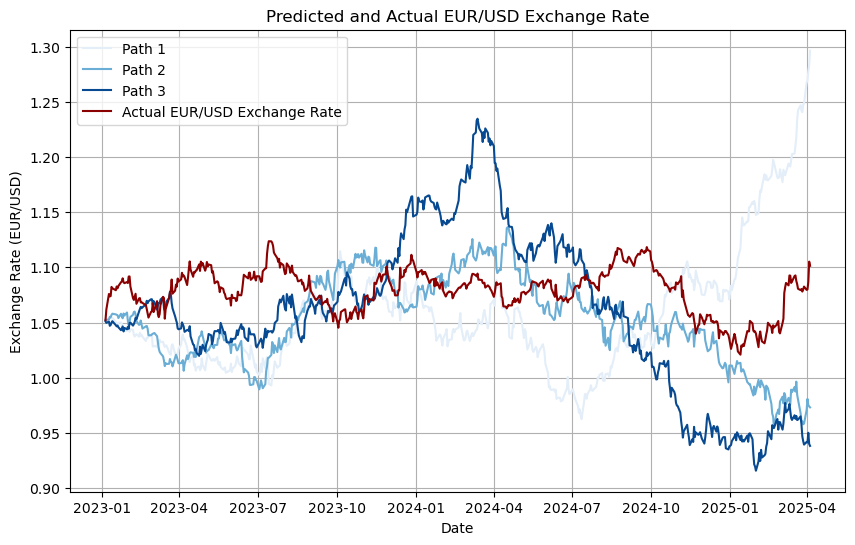

In [48]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
# 当前汇率 (S0) 为测试集中的第一个价格
S0 = test_data['Price'].iloc[0]

# 预测时间段的长度
T = 21 / 252  # 期权到期时间为 1 个月（21 个交易日）
dt = 1 / 252  # 时间间隔，假设一年有252个交易日
T_steps = len(test_data) # 使用测试集的天数作为时间范围
N = 3  # 生成的路径数量

# Heston模型的参数 (调整这些参数来控制波动性)
kappa = 3  # 波动率均值回归速度 (可以增大此值来减小波动)
theta = 0.01  # 波动率均值
sigma_v = 0.01  # 波动率的波动性 (减小此值会降低波动的幅度)

# 初始化汇率路径数组
S = np.zeros((N, T_steps + 1))  # N 条路径，T+1 是因为有 T+1 个时间点
S[:, 0] = S0  # 所有路径的初始汇率为 S0
v = np.zeros((N, T_steps + 1))  # 存储每条路径的波动率
v[:, 0] = sigma[0]**2  # 初始波动率

np.random.seed(42)  # 为了结果可复现

for i in range(N):
    for t in range(1, T_steps + 1):
        # 生成标准正态分布的随机变量
        Z_t1 = np.random.normal(0, 1)  # 对于股票价格的随机波动
        Z_t2 = np.random.normal(0, 1)  # 对于波动率的随机波动

        # 波动率的动态过程
        v[i, t] = v[i, t-1] + kappa * (theta - v[i, t-1]) * dt + sigma_v * np.sqrt(v[i, t-1]) * np.sqrt(dt) * Z_t2
        
        # 使用Heston模型更新汇率
        dS = (mu - 0.5 * v[i, t]) * dt + np.sqrt(v[i, t]) * np.sqrt(dt) * Z_t1
        S[i, t] = S[i, t-1] * np.exp(dS)

# 创建一个浅蓝色到灰色的渐变色映射
colors = cm.Blues(np.linspace(0.1, 0.9, N))  # 渐变从浅蓝色到中蓝色

# 可视化汇率路径预测，模拟的路径使用浅蓝色到灰色
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(test_data.index, S[i, 1:], label=f'Path {i+1}', color=colors[i])  # 使用渐变的蓝色

# 设置实际汇率为深红色
plt.plot(test_data.index, test_data['Price'], label="Actual EUR/USD Exchange Rate", color='darkred', alpha=1)
plt.title('Predicted and Actual EUR/USD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (EUR/USD)')
plt.legend()
plt.grid(True)
plt.show()


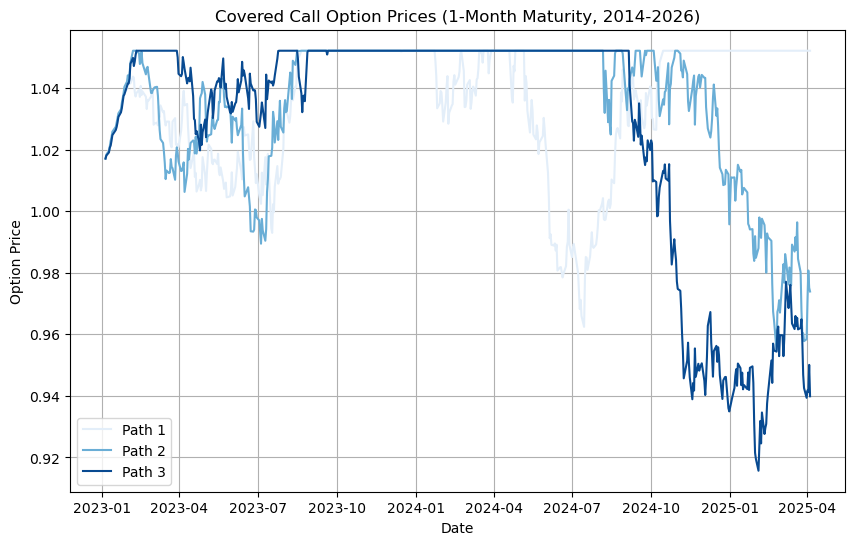

In [61]:
from scipy.stats import norm
# 期权定价参数
K_covered_call = test_data['Price'].iloc[0]  # 行权价设为初始汇率

# 定义 Garman-Kohlhagen 模型计算看涨期权价格（向量化）
def garman_kohlhagen_call(S, K, r_d, r_f, T, sigma):
    d1 = (np.log(S / K) + (r_d - r_f + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * np.exp(-r_f * T) * norm.cdf(d1) - K * np.exp(-r_d * T) * norm.cdf(d2)
    return call_price

# 期权价格计算
covered_call_prices = np.zeros((N, T_steps))  # 初始化 Covered Call 价格矩阵
current_times = np.arange(T_steps) * dt  # 当前时间（以年为单位）

# 计算每条路径每个时间步的 Covered Call 价值
for t in range(T_steps):
    # 计算当前时间步的剩余到期时间
    time_to_expiration = max(T - (t * dt), 1e-6)  # 计算剩余到期时间

    # 计算每条路径当前时间步的期权价格
    call_prices = garman_kohlhagen_call(
        S[:, t],  # 当前路径的汇率
        K_covered_call,  # 行权价
        test_data['USD_Rate'].values[t],  # 当前时间步的美元利率
        test_data['EUR_Rate'].values[t],  # 当前时间步的欧元利率
        time_to_expiration,  # 剩余到期时间
        np.sqrt(v[:, t])  # 当前路径的波动率
    )

    # 计算 Covered Call 价值
    covered_call_prices[:, t] = S[:, t] - call_prices  # 汇率 - 期权价格

# 可视化 Covered Call 价格路径
plt.figure(figsize=(10, 6))

# 绘制每条路径的 Covered Call 价格
for i in range(N):
    plt.plot(test_data.index[:T_steps], covered_call_prices[i, :], label=f'Path {i+1}', color=colors[i])  # 使用渐变的蓝色

# 添加标题和标签
plt.title('Covered Call Option Prices (1-Month Maturity, 2014-2026)')
plt.xlabel('Date')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()


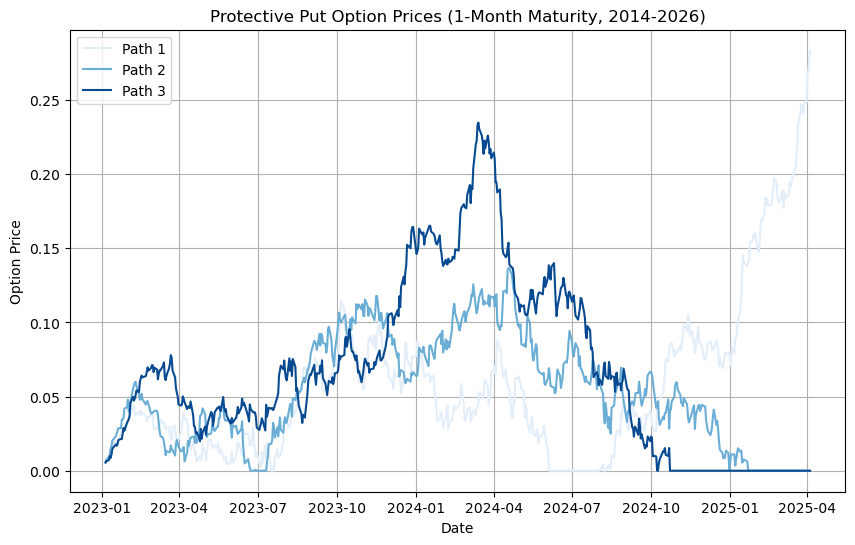

In [62]:
# 期权定价参数
K_protective_put = test_data['Price'].iloc[0]  # 行权价设为初始汇率

# 计算 Protective Put 策略价格
def protective_put(S, K, r_d, r_f, T, sigma):
    call_price = garman_kohlhagen_call(S, K, r_d, r_f, T, sigma)  # 计算看涨期权价格
    put_price = garman_kohlhagen_call(S, K, r_f, r_d, T, sigma)  # 利率颠倒计算看跌期权
    protective_put_price = S - put_price  # 基础资产 - 看跌期权的价格
    return protective_put_price

# Protective Put 计算
protective_put_prices = np.zeros((N, T_steps))  # 初始化 Protective Put 价格矩阵
current_times = np.arange(T_steps) * dt  # 当前时间（以年为单位）

for t in range(T_steps):
    time_to_expiration = max(T - (t * dt), 1e-6)  # 剩余到期时间
    put_prices = protective_put(
        S[:, t],  # 当前路径的汇率
        K_protective_put,  # 行权价
        test_data['USD_Rate'].values[t],  # 当前时间步的美元利率
        test_data['EUR_Rate'].values[t],  # 当前时间步的欧元利率
        time_to_expiration,  # 剩余到期时间
        np.sqrt(v[:, t])  # 当前路径的波动率
    )
    protective_put_prices[:, t] = S[:, t] - put_prices  # 汇率 - 看跌期权价格

# 可视化 Protective Put 价格路径
plt.figure(figsize=(10, 6))

# 绘制每条路径的 Protective Put 价格
for i in range(N):
    plt.plot(test_data.index[:T_steps], protective_put_prices[i, :], label=f'Path {i+1}', color=colors[i])  # 使用渐变的蓝色

# 添加标题和标签
plt.title('Protective Put Option Prices (1-Month Maturity, 2014-2026)')
plt.xlabel('Date')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()


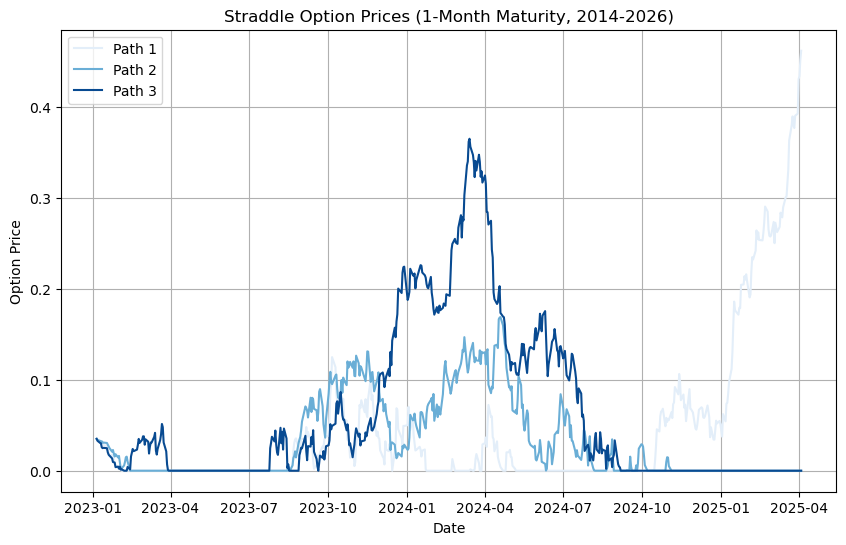

In [67]:
# 期权定价参数
K_straddle = test_data['Price'].iloc[0]  # 行权价设为初始汇率

# 计算 Straddle 策略价格
def straddle(S, K, r_d, r_f, T, sigma):
    call_price = garman_kohlhagen_call(S, K, r_d, r_f, T, sigma)  # 看涨期权价格
    put_price = garman_kohlhagen_call(S, K, r_f, r_d, T, sigma)  # 看跌期权价格
    straddle_price = call_price + put_price  # 同时购买看涨和看跌期权
    return straddle_price

# Straddle 计算
straddle_prices = np.zeros((N, T_steps))  # 初始化 Straddle 价格矩阵
current_times = np.arange(T_steps) * dt  # 当前时间（以年为单位）

for t in range(T_steps):
    # 计算当前时间步的剩余到期时间
    time_to_expiration = max(T - (t * dt), 1e-6)  # 计算剩余到期时间

    # 计算每条路径当前时间步的期权价格
    straddle_price = straddle(
        S[:, t],  # 当前路径的汇率
        K_straddle,  # 行权价
        test_data['USD_Rate'].values[t],  # 当前时间步的美元利率
        test_data['EUR_Rate'].values[t],  # 当前时间步的欧元利率
        time_to_expiration,  # 剩余到期时间
        np.sqrt(v[:, t])  # 当前路径的波动率
    )
    straddle_prices[:, t] = straddle_price  # 看涨期权 + 看跌期权的价格

# 可视化 Straddle 价格路径
plt.figure(figsize=(10, 6))

# 绘制每条路径的 Straddle 价格
for i in range(N):
    plt.plot(test_data.index[:T_steps], straddle_prices[i, :], label=f'Path {i+1}', color=colors[i])  # 使用渐变的蓝色

# 添加标题和标签
plt.title('Straddle Option Prices (1-Month Maturity, 2014-2026)')
plt.xlabel('Date')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()


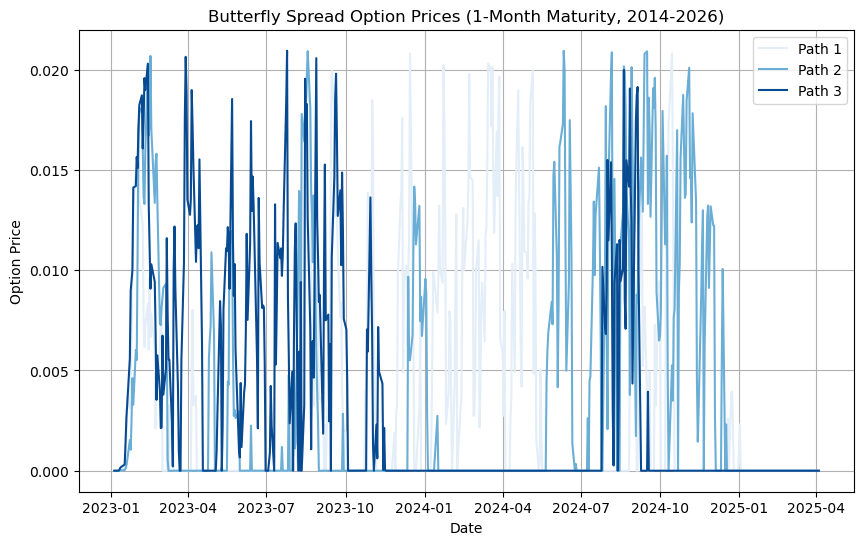

In [64]:
# 期权定价参数
K_low = test_data['Price'].iloc[0] * 0.98  # 低行权价设为初始汇率的97%
K_mid = test_data['Price'].iloc[0]  # 中行权价设为初始汇率
K_high = test_data['Price'].iloc[0] * 1.02  # 高行权价设为初始汇率的103%

# 计算 Butterfly Spread 策略价格
def butterfly_spread(S, K_low, K_mid, K_high, r_d, r_f, T, sigma):
    # 计算低、中、高行权价的期权价格
    low_call_price = garman_kohlhagen_call(S, K_low, r_d, r_f, T, sigma)
    mid_call_price = garman_kohlhagen_call(S, K_mid, r_d, r_f, T, sigma)
    high_call_price = garman_kohlhagen_call(S, K_high, r_d, r_f, T, sigma)
    
    # Butterfly Spread 策略的期权价格
    butterfly_price = low_call_price - 2 * mid_call_price + high_call_price
    return butterfly_price

# Butterfly Spread 计算
butterfly_spread_prices = np.zeros((N, T_steps))  # 初始化 Butterfly Spread 价格矩阵
current_times = np.arange(T_steps) * dt  # 当前时间（以年为单位）

for t in range(T_steps):
    time_to_expiration = max(T - (t * dt), 1e-6)  # 剩余到期时间
    spread_prices = butterfly_spread(
        S[:, t],  # 当前路径的汇率
        K_low,  # 低行权价
        K_mid,  # 中行权价
        K_high,  # 高行权价
        test_data['USD_Rate'].values[t],  # 当前时间步的美元利率
        test_data['EUR_Rate'].values[t],  # 当前时间步的欧元利率
        time_to_expiration,  # 剩余到期时间
        np.sqrt(v[:, t])  # 当前路径的波动率
    )
    butterfly_spread_prices[:, t] = spread_prices  # 计算 Butterfly Spread 策略的价格

# 可视化 Butterfly Spread 价格路径
plt.figure(figsize=(10, 6))

# 绘制每条路径的 Butterfly Spread 价格
for i in range(N):
    plt.plot(test_data.index[:T_steps], butterfly_spread_prices[i, :], label=f'Path {i+1}', color=colors[i])  # 使用渐变的蓝色

# 添加标题和标签
plt.title('Butterfly Spread Option Prices (1-Month Maturity, 2014-2026)')
plt.xlabel('Date')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()


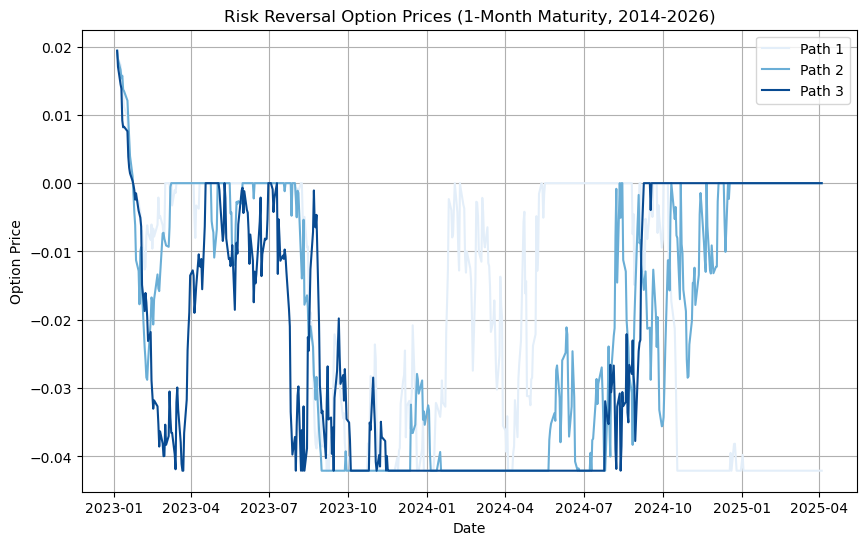

In [65]:
# 期权定价参数
K_risk_reversal_call = test_data['Price'].iloc[0] * 1.02  # 高行权价设为初始汇率的105%
K_risk_reversal_put = test_data['Price'].iloc[0] * 0.98  # 低行权价设为初始汇率的95%

# 计算 Risk Reversal 策略价格
def risk_reversal(S, K_call, K_put, r_d, r_f, T, sigma):
    call_price = garman_kohlhagen_call(S, K_call, r_d, r_f, T, sigma)  # 计算看涨期权价格
    put_price = garman_kohlhagen_call(S, K_put, r_f, r_d, T, sigma)  # 计算看跌期权价格
    risk_reversal_price = call_price - put_price  # 购买看涨期权并卖出看跌期权
    return risk_reversal_price

# Risk Reversal 计算
risk_reversal_prices = np.zeros((N, T_steps))  # 初始化 Risk Reversal 价格矩阵
current_times = np.arange(T_steps) * dt  # 当前时间（以年为单位）

for t in range(T_steps):
    time_to_expiration = max(T - (t * dt), 1e-6)  # 剩余到期时间
    reversal_prices = risk_reversal(
        S[:, t],  # 当前路径的汇率
        K_risk_reversal_call,  # 看涨期权行权价
        K_risk_reversal_put,  # 看跌期权行权价
        test_data['USD_Rate'].values[t],  # 当前时间步的美元利率
        test_data['EUR_Rate'].values[t],  # 当前时间步的欧元利率
        time_to_expiration,  # 剩余到期时间
        np.sqrt(v[:, t])  # 当前路径的波动率
    )
    risk_reversal_prices[:, t] = reversal_prices  # 计算 Risk Reversal 策略的价格

# 可视化 Risk Reversal 价格路径
plt.figure(figsize=(10, 6))

# 绘制每条路径的 Risk Reversal 价格
for i in range(N):
    plt.plot(test_data.index[:T_steps], risk_reversal_prices[i, :], label=f'Path {i+1}', color=colors[i])  # 使用渐变的蓝色

# 添加标题和标签
plt.title('Risk Reversal Option Prices (1-Month Maturity, 2014-2026)')
plt.xlabel('Date')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()
